<a href="https://colab.research.google.com/github/marinabar/hugging_face/blob/main/baseline_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports



In [ ]:
!pip install -U transformers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 4.8 MB/s eta 0:00:00


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00


In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.7 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Import preferred dataset

In [ ]:
from datasets import load_dataset

food = load_dataset("food101", split="train[:5000]")
#create test split
food = food.train_test_split(test_size=0.2)

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

In [ ]:
dataset=food

In [55]:
dataset["train"][19]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'label': 81,
 'pixel_values': tensor([[[-0.9765, -0.9686, -0.9686,  ...,  0.0902,  0.0824,  0.0667],
          [-0.9765, -0.9686, -0.9608,  ...,  0.1059,  0.0980,  0.0902],
          [-0.9686, -0.9686, -0.9686,  ...,  0.1216,  0.1294,  0.1294],
          ...,
          [ 0.7569,  0.7882,  0.8118,  ..., -0.1529, -0.2235, -0.2314],
          [ 0.7490,  0.7490,  0.7961,  ..., -0.0510, -0.1451, -0.1529],
          [ 0.7098,  0.7490,  0.7804,  ...,  0.0588, -0.0196, -0.0431]],
 
         [[-0.9373, -0.9294, -0.9451,  ..., -0.2471, -0.2392, -0.2549],
          [-0.9451, -0.9373, -0.9451,  ..., -0.2314, -0.2157, -0.2235],
          [-0.9529, -0.9608, -0.9529,  ..., -0.2078, -0.2000, -0.2000],
          ...,
          [ 0.4667,  0.4980,  0.5216,  ..., -0.4667, -0.5843, -0.6157],
          [ 0.4588,  0.4588,  0.5059,  ..., -0.3569, -0.5059, -0.5451],
          [ 0.4118,  0.4588,  0.4902,  ..., -0.2314, -0.3804, -0.4510]

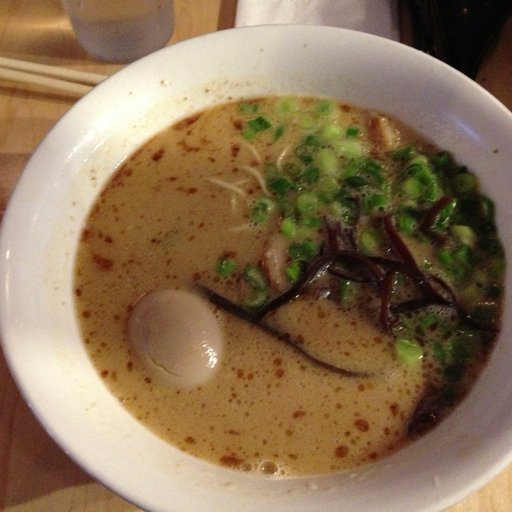

In [56]:
dataset["train"][19]["image"]

In [ ]:
labels = dataset["train"].features["label"].names

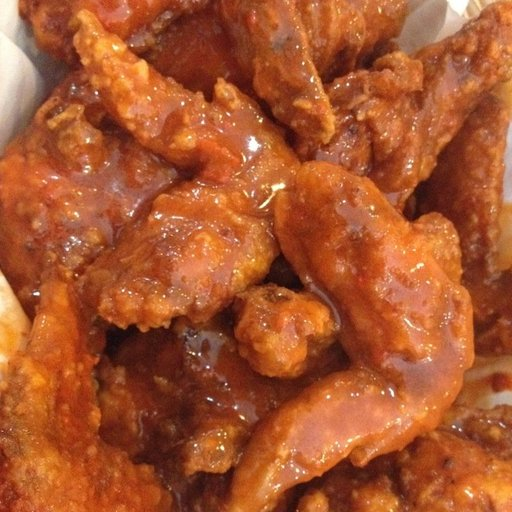

In [ ]:
example = dataset["train"][10]['image']
example

In [ ]:
dataset['train'].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lo

Create dicts mapping id to label name

In [ ]:
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

### Preprocess dataset according to model configuration

In [ ]:
batch_size = 16
model_config='google/vit-base-patch16-224-in21k'

Here we are using ViT's config

### Augment data

In [ ]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_config)
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
from torchvision.transforms import CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, Resize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            Resize(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(examples):
    """Apply train_transforms across a batch."""
    examples["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in examples["image"]
    ]
    return examples

def preprocess_val(examples):
    """Apply val_transforms across a batch."""
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

Huggingface function to automatically map augmentation function and convert image to tensors

In [ ]:
train_ds = dataset['train']
val_ds = dataset['test']

In [ ]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

### Define metrics and analyzing function

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

### Define model

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_config,
    num_labels=len(labels),
    #label2id=label2id,
    #id2label=id2label,
    ignore_mismatched_sizes = True, # provide this to fine-tune an already fine-tuned checkpoint
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
for name, param in model.named_parameters():
    if 'classifier' not in name:
      param.requires_grad=False

In [ ]:
for name, param in model.named_parameters():
    print(name,param.requires_grad)

In [ ]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
# define hyperparameters
training_args = TrainingArguments(
    "foodievit", #name of the model we are going to save
    remove_unused_columns=False, # set as False otherwise will drop image coljmns
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    hub_model_id="m1b/foodievit"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor, #pre processing function
    compute_metrics=compute_metrics,# metrics function
    data_collator=collate_fn,
)

In [ ]:
results=trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,4.049000,4.030387,0.725000
2,3.787200,3.743203,0.803000
2,3.539100,3.499889,0.833000
4,3.304400,3.290426,0.849000
4,3.130600,3.121021,0.855000
6,2.982900,2.983241,0.864000
6,2.890700,2.880143,0.867000
8,2.784800,2.807128,0.870000
8,2.766400,2.765249,0.874000
9,2.750200,2.752452,0.873000


In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       9.92
  eval_accuracy           =      0.874
  eval_loss               =     2.7652
  eval_runtime            = 0:00:15.28
  eval_samples_per_second =     65.421
  eval_steps_per_second   =      4.122


Evaluate:

In [113]:
from PIL import Image
import requests

url = 'https://assets.tmecosys.com/image/upload/t_web767x639/img/recipe/ras/Assets/ae8457a1-5f09-4f6e-a20c-bda33faeb4ad/Derivates/c632d805-2769-4b90-bb8c-6f11b90cb7ca.jpg'
image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "./foodievit"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

In [114]:
encoding = image_processor(image.convert("RGB"), return_tensors="pt")

In [115]:
# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

#get probabilities
prob=torch.nn.functional.softmax(logits, dim=1) #convert logits to prob
prob=prob.sort(descending=True)[0][0][:5].tolist() # get top 5 prob

# get top five categories
top5=logits.argsort(descending=True)[0][:5].tolist()

print(*[f"Predicted {i+1} class: {id2label[str(top5[i])]} - probability : {round(prob[i], 4)} \n" for i in range(5)])

Predicted 1 class: beignets - probability : 0.0613 
 Predicted 2 class: prime_rib - probability : 0.0225 
 Predicted 3 class: chicken_wings - probability : 0.0224 
 Predicted 4 class: hamburger - probability : 0.0221 
 Predicted 5 class: pork_chop - probability : 0.0204 

